# code2vec model
## Выглядит так: 
![code2vec](img/code2vec_network.png)

1. context vectors получаются из path context reader.
2. Преобразовываются fully connected layer в какой-то embed
3. 


In [1]:
%cd ../

/home/rkulagin/university/IU8-8-3/TiMP-course-project/code/code2vec


In [2]:
import tensorflow as tf
import tensorboard
import os
import datetime
import config
import numpy as np
from vocabulary import Code2VecVocabs
from path_context_reader import PathContextReader, ReaderInputTensors
config.config.CREATE_VOCAB = True
config.config.TRAINING_FREQ_DICTS_PATH = "dataset/java-small/java-small.c2v.dict"
c2v_vocabs = Code2VecVocabs()
pcr = PathContextReader(is_train=True, vocabs=c2v_vocabs, csv_path="dataset/java-small/java-small.train_vec.csv")
dataset = pcr.get_dataset()
#init lookups
c2v_vocabs.target_vocab.get_word_to_index_lookup_table()
c2v_vocabs.token_vocab.get_word_to_index_lookup_table()
c2v_vocabs.path_vocab.get_word_to_index_lookup_table()


Creating vocab from dataset/java-small/java-small.c2v.dict
Loading frequency dicts from dataset/java-small/java-small.c2v.dict
Loading token freq dict
Loading path freq dict
Loading target freq dict
Creating token vocab
Creating vocab from frequency dictionary of 3367 elements
Created token vocab
Creating path vocab
Creating vocab from frequency dictionary of 35452 elements
Created path vocab
Creating target vocab
Creating vocab from frequency dictionary of 618 elements
Created target vocab
Created all vocabs


In [3]:
EMBED_DIMENSION = 200
DROPOUT_KEEP_RATE = 0.75
TOKEN_VOCAB_SIZE = c2v_vocabs.token_vocab.lookup_table_word_to_index.size().numpy()
TARGET_VOCAB_SIZE=c2v_vocabs.target_vocab.lookup_table_word_to_index.size().numpy()
PATH_VOCAB_SIZE = c2v_vocabs.path_vocab.lookup_table_word_to_index.size().numpy()

In [4]:
source_token_embed = tf.keras.layers.Embedding(input_dim=c2v_vocabs.token_vocab.lookup_table_word_to_index.size(), 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform')
target_token_embed = tf.keras.layers.Embedding(input_dim=c2v_vocabs.token_vocab.lookup_table_word_to_index.size(), 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform')
target_embed = tf.keras.layers.Embedding(input_dim=c2v_vocabs.target_vocab.lookup_table_word_to_index.size(), 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform')
path_embed = tf.keras.layers.Embedding(input_dim=c2v_vocabs.path_vocab.lookup_table_word_to_index.size(), 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform')

In [5]:
iterator = iter(dataset)


In [6]:
input_indexes = iterator.get_next()

In [7]:
s_t_e = source_token_embed(input_indexes.path_source_token_indices)
s_t_e = tf.squeeze(s_t_e)

In [8]:
t_t_e = target_token_embed(input_indexes.path_target_token_indices)
p_e = path_embed(input_indexes.path_indices)
t_t_e = tf.squeeze(t_t_e)
p_e = tf.squeeze(p_e)

In [9]:
context_embed = tf.keras.layers.Concatenate()([s_t_e, p_e, t_t_e])


In [10]:
context_embed = tf.keras.layers.Concatenate()([s_t_e, p_e, t_t_e])
droped = tf.keras.layers.Dropout(1-DROPOUT_KEEP_RATE)(context_embed)
flat_embed = tf.keras.layers.Reshape((-1, 3*EMBED_DIMENSION))(droped)
f_e = tf.keras.layers.Dense((config.config.BATCH_SIZE*config.config.MAX_CONTEXTS, 3*EMBED_DIMENSION), activation=tf.nn.tanh, use_bias=True) (flat_embed)
context_weights = tf.keras.layers.Dense((config.config.BATCH_SIZE*config.config.MAX_CONTEXTS, 1))(f_e)
batched_context_weights = tf.keras.layers.Reshape((config.config.BATCH_SIZE, config.confign.MAX_CONTEXTS, 1))(context_weights)
attention_weights = tf.keras.layers.Softmax(axis=1)(batched_context_weights)
batched_embeed = tf.keras.layers.Reshape((-1, self.config.MAX_CONTEXTS, 3*EMBED_DIMENSION))(f_e)
code_vectors = tf.keras.layers.multiply(batched_embeed, attention_weights)
code_vectors

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [11]:
c2v_vocabs.token_vocab.lookup_table_word_to_index.size().numpy()
input_data = input_indexes

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
source_token_embed (Embeddin (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
paths_embed (Embedding)      (None, 300, 200)          7090600   
Total params: 7,090,600
Trainable params: 7,090,600
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_token_embed (Embeddin (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-

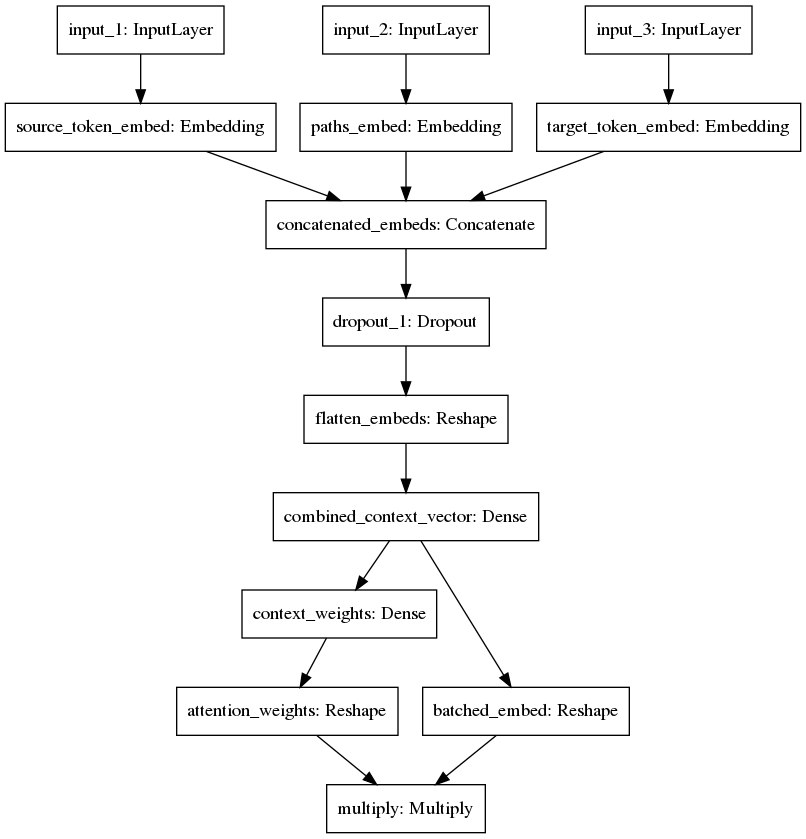

In [12]:
input_source_token_embed = tf.keras.Input(shape = (config.config.MAX_CONTEXTS,))
source_token_embed = tf.keras.layers.Embedding(input_dim = TOKEN_VOCAB_SIZE, 
                                    output_dim=EMBED_DIMENSION,
                                    embeddings_initializer='uniform',
                                    name="source_token_embed") 
model_1 = tf.keras.Sequential([input_source_token_embed, source_token_embed])
m_1 = model_1(input_data.path_source_token_indices)

print(model_1.summary())

input_paths_embed = tf.keras.Input(shape=(config.config.MAX_CONTEXTS,))
paths_embed = tf.keras.layers.Embedding(input_dim=PATH_VOCAB_SIZE, output_dim=EMBED_DIMENSION, embeddings_initializer='uniform', name="paths_embed")
model_2 = tf.keras.Sequential([input_paths_embed, paths_embed])
m_2 = model_2(input_data.path_indices)
print(model_2.summary())


input_target_token_embed = tf.keras.Input(shape=(config.config.MAX_CONTEXTS,))
target_token_embed = tf.keras.layers.Embedding(input_dim=TOKEN_VOCAB_SIZE, 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform',
                                              name="target_token_embed")
model_3 = tf.keras.Sequential([input_target_token_embed, target_token_embed])
m_3 = model_3(input_data.path_source_token_indices)
print(model_3.summary())


input_target_embed = tf.keras.Input(shape=(config.config.MAX_CONTEXTS,))
target_embed = tf.keras.layers.Embedding(input_dim=TARGET_VOCAB_SIZE, 
                                        output_dim=EMBED_DIMENSION,
                                        embeddings_initializer='uniform',
                                        name="target_embed")
model_4 = tf.keras.Sequential([input_target_embed,target_embed])
m_4 = model_4(input_data.target_index)
print(model_4.summary())


concatenated_embeds = tf.keras.layers.Concatenate(name="concatenated_embeds")([model_1.output, model_2.output, model_3.output])

droped_embeds = tf.keras.layers.Dropout(1-DROPOUT_KEEP_RATE)(concatenated_embeds)
flatten_embeds = tf.keras.layers.Reshape((-1, 3*EMBED_DIMENSION), name="flatten_embeds")(droped_embeds)
combined_context_vector = tf.keras.layers.Dense(3*EMBED_DIMENSION, activation='tanh', name="combined_context_vector")(flatten_embeds)
сontext_weights = tf.keras.layers.Dense(1, activation='softmax', name="context_weights")(combined_context_vector)
attention_weights = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 1), name="attention_weights")(сontext_weights)
batched_embed = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 3*EMBED_DIMENSION), name="batched_embed") (combined_context_vector)
code_vectors = tf.keras.layers.Multiply()([batched_embed, attention_weights])

out_model = tf.keras.Model(inputs=[model_1.input, model_2.input, model_3.input], outputs=code_vectors)
print(out_model.summary())
tf.keras.utils.plot_model(out_model)

In [ ]:
train(input_indexes)

In [ ]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.Input(shape=(1000, 600)))
m.add(tf.keras.layers.Dense(600))
m.add(tf.keras.layers.Softmax())
m.summary()

In [ ]:
a = np.ones((1, 300, 600))
b = np.ones((1, 300, 1))
tf.multiply(a, b)